In [1]:
import json
from pathlib import Path

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [2]:
# attempt to enable LaTeX rendering
# change to `False` if you get an error during plotting (latex not installed)
plt.rcParams['text.usetex'] = True

### Metrics

In [3]:
def read_metrics(file_name):
    """ Read metrics """
    with open(file_name, 'r') as file:
        data = json.load(file)
    eval_accuracy = data.get("eval_accuracy", None)
    perplexity = data.get("perplexity", None)
    return eval_accuracy, perplexity


def read_history(file_name, max_step=46350):
    """ Read history """
    with open(file_name, 'r') as file:
        data = json.load(file)
    steps_and_losses = []
    for log in data.get("log_history", []):
        step = log.get("step", None)
        loss = log.get("loss", None)
        if step is not None and loss is not None and step <= max_step:
            steps_and_losses.append([step, loss])
    return np.array(steps_and_losses)

In [4]:
seeds = list(range(10))
out_dir = Path("./results/gpt2_paper")


def print_metrics(kgi):
    losses = []
    slowness = []
    accs = []
    pplx = []
    for seed in seeds:
        # read history
        name = f"{seed}_{kgi}"
        hist = read_history(out_dir / name / "trainer_state.json")[:, 1]
        # use average of last 250 steps (5 * 50) as final loss
        final_loss = hist[-5:].mean()
        losses.append(final_loss)
        # AUC for convergence slowness
        init_loss = hist[:5].mean()
        slowness.append(hist.mean() / init_loss)
        # read accuracy
        acc, ppl = read_metrics(out_dir / name / "eval_results.json")
        accs.append(acc)
        pplx.append(ppl)
    losses = np.array(losses) * 100
    pplx = np.array(pplx)
    slowness = np.array(slowness)
    accs = np.array(accs) * 100
    # exclude top
    idx = np.argsort(losses)
    losses = losses[idx[:5]]
    slowness = slowness[idx[:5]]
    accs = accs[idx[:5]]
    print("KGI" if kgi else "No KGI")
    # print in latex format
    print("\nKGI" if kgi else "\nNo KGI")
    print(f"Loss: {losses.mean():.2f} ± {losses.mean():.2f}")
    print(f"slowness: {slowness.mean():.2f} ± {slowness.std():.2f}")
    print(f"Accuracy: {accs.mean():.1f} ± {accs.std():.1f}%")
    print(f"Perplexity: {pplx.mean():.1f} ± {pplx.std():.1f}")
    return losses.mean(), losses.std(), slowness.mean(), slowness.std(), accs.mean(), accs.std()


lmf, lsf, smf, ssf, amf, asf = print_metrics(False)
lmt, lst, smt, sst, amt, ast = print_metrics(True)
print("\nCopy to table")
print(f"GPT-2 & "
      f"${lmf:.2f}\!\pm\!{lsf:.2f}$ & ${lmt:.2f}\!\pm\!{lst:.2f}$ & "
      f"${smf:.2f}\!\pm\!{ssf:.2f}$ & ${smt:.2f}\!\pm\!{sst:.2f}$ & Accuracy & "
      f"${amf:.2f}\!\pm\!{asf:.2f}\%$ & ${amt:.2f}\!\pm\!{ast:.2f}\%$")

No KGI

No KGI
Loss: 1.75 ± 1.75
slowness: 0.15 ± 0.00
Accuracy: 20.6 ± 0.2%
Perplexity: 858749.1 ± 112610.3
KGI

KGI
Loss: 1.38 ± 1.38
slowness: 0.14 ± 0.01
Accuracy: 20.9 ± 0.2%
Perplexity: 931673.7 ± 95597.7

Copy to table
GPT-2 & $1.75\!\pm\!0.13$ & $1.38\!\pm\!0.19$ & $0.15\!\pm\!0.00$ & $0.14\!\pm\!0.01$ & Accuracy & $20.56\!\pm\!0.18\%$ & $20.89\!\pm\!0.21\%$


### Loss history

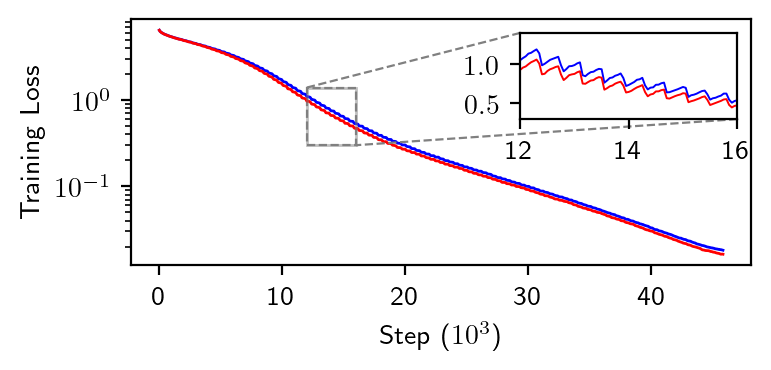

In [5]:
def moving_ave(series, window_size):
    """ Moving average to smooth the loss history a little bit """
    return np.convolve(series, np.ones(window_size) / window_size, mode='valid')


_, ax = plt.subplots(figsize=(10 / 2.5, 4 / 2.5), dpi=200)
seed_ = 0
hist_def = read_history(out_dir / f"{seed_}_{False}" / "trainer_state.json")[:, 1]
hist_kgi = read_history(out_dir / f"{seed_}_{True}" / "trainer_state.json")[:, 1]
ax.plot(np.arange(0, 46350 // 50 - 9), moving_ave(hist_def, 10), label="No KGI", lw=1, c='b')
ax.plot(np.arange(0, 46350 // 50 - 9), moving_ave(hist_kgi, 10), label="KGI", lw=1, c='r')
ticks = np.array([0, 200, 400, 600, 800])
ax.set_xticks(ticks, ticks * 50 // 1000)
ax.set_ylabel("Training Loss")
ax.set_xlabel("Step ($10^3$)")
ax.set_yscale("log")

axins = inset_axes(ax, width="35%", height="35%", loc='upper right')
axins.plot(np.arange(0, 46350 // 50), moving_ave(hist_def, 1), lw=.7, c='b')
axins.plot(np.arange(0, 46350 // 50), moving_ave(hist_kgi, 1), lw=.7, c='r')
axins.set_xlim(250, 300)
axins.set_ylim(.3, 1.4)
axins.set_xticks([240, 280, 320], [12, 14, 16])
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=.8, zorder=-1, ls="--")
ax.indicate_inset_zoom(axins)
plt.show()

# Plot all histories in on figure

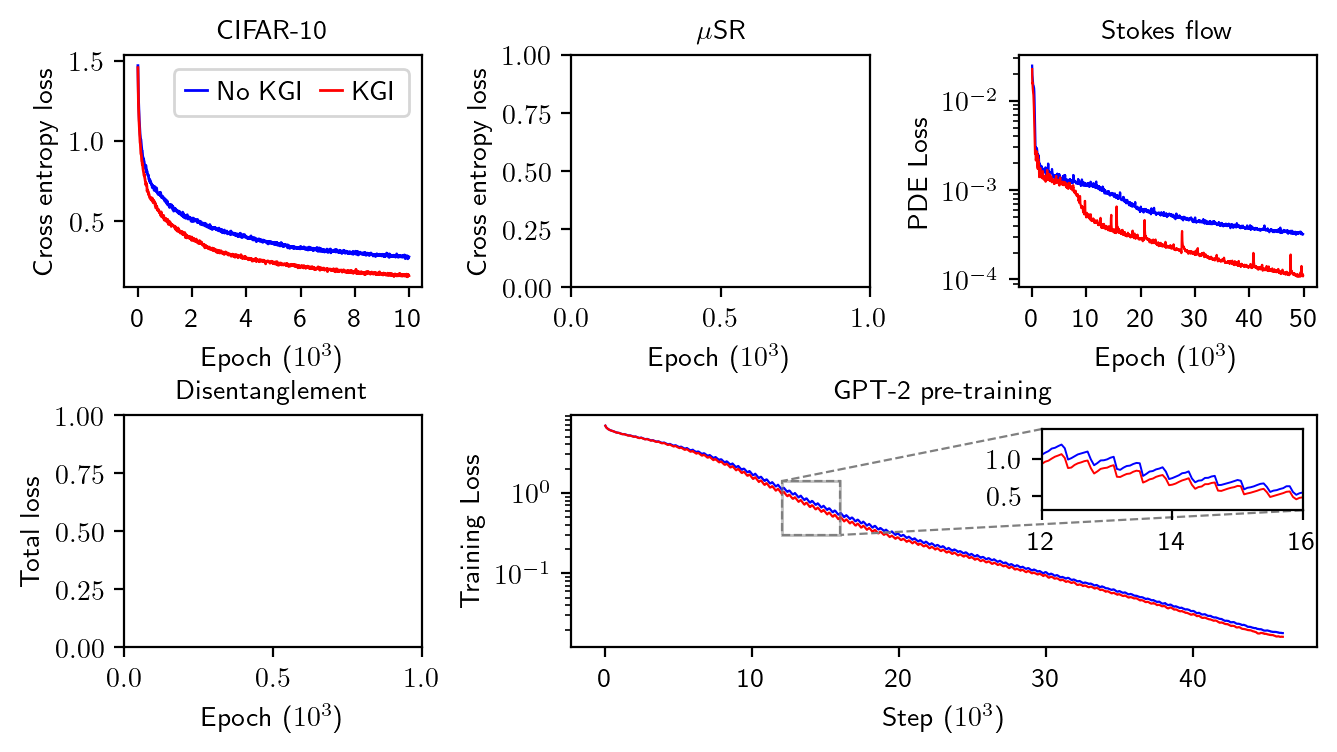

In [6]:
fig = plt.figure(figsize=(10 / 1.3, 5 / 1.3), dpi=200)
gs = gridspec.GridSpec(2, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0])
ax5 = fig.add_subplot(gs[1, 1:])
plt.subplots_adjust(wspace=0.5, hspace=0.55)

# CIFAR-10
ax = ax1
seed_ = 0
out_dir = Path("results/cifar10_paper")
hist_def = np.loadtxt(out_dir / f"{seed_}_{False}")
hist_kgi = np.loadtxt(out_dir / f"{seed_}_{True}")
ax.plot(np.arange(1, 10000 + 1, 10), moving_ave(hist_def, 1), label="No KGI", lw=1, c='b')
ax.plot(np.arange(1, 10000 + 1, 10), moving_ave(hist_kgi, 1), label="KGI", lw=1, c='r')
ax.set_xticks([0, 2000, 4000, 6000, 8000, 10000],
              [0, 2, 4, 6, 8, 10])
ax.set_ylabel("Cross entropy loss")
ax.set_xlabel("Epoch ($10^3$)")
ax.legend(ncol=2, handlelength=.8, columnspacing=.5, handletextpad=.4)
ax.set_title("CIFAR-10", fontsize=10)

# Muon
ax = ax2
ax.set_ylabel("Cross entropy loss")
ax.set_xlabel("Epoch ($10^3$)")
ax.set_title("$\mu$SR", fontsize=10)

# Stokes
ax = ax3
seed_ = 2
out_dir = Path("results/deeponet_paper")
hist_def = np.loadtxt(out_dir / f"{seed_}_{False}")[:, -1]
hist_kgi = np.loadtxt(out_dir / f"{seed_}_{True}")[:, -1]
ax.plot(np.arange(0, 50000 // 20 - 3), moving_ave(hist_def, 5), label="No KGI", lw=.8, c='b')
ax.plot(np.arange(0, 50000 // 20 - 3), moving_ave(hist_kgi, 5), label="KGI", lw=.8, c='r')
ax.set_xticks([0, 10000 // 20, 20000 // 20, 30000 // 20, 40000 // 20, 50000 // 20],
              [0, 10, 20, 30, 40, 50])
ax.set_ylabel("PDE Loss")
ax.set_xlabel("Epoch ($10^3$)")
ax.set_yscale("log")
ax.set_title('Stokes flow', fontsize=10)

# disentanglement
ax = ax4
ax.set_ylabel("Total loss")
ax.set_xlabel("Epoch ($10^3$)")
ax.set_title("Disentanglement", fontsize=10)

# GPT-2
ax = ax5
seed_ = 0
out_dir = Path("results/gpt2_paper")
hist_def = read_history(out_dir / f"{seed_}_{False}" / "trainer_state.json")[:, 1]
hist_kgi = read_history(out_dir / f"{seed_}_{True}" / "trainer_state.json")[:, 1]
ax.plot(np.arange(0, 46350 // 50 - 4), moving_ave(hist_def, 5), label="No KGI", lw=.8, c='b')
ax.plot(np.arange(0, 46350 // 50 - 4), moving_ave(hist_kgi, 5), label="KGI", lw=.8, c='r')
ticks = np.array([0, 200, 400, 600, 800])
ax.set_xticks(ticks, ticks * 50 // 1000)
ax.set_ylabel("Training Loss")
ax.set_xlabel("Step ($10^3$)")
ax.set_yscale("log")

axins = inset_axes(ax, width="35%", height="35%", loc='upper right')
axins.plot(np.arange(0, 46350 // 50), moving_ave(hist_def, 1), lw=.7, c='b')
axins.plot(np.arange(0, 46350 // 50), moving_ave(hist_kgi, 1), lw=.7, c='r')
axins.set_xlim(250, 300)
axins.set_ylim(.3, 1.4)
axins.set_xticks([240, 280, 320], [12, 14, 16])
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5", lw=.8, zorder=-1, ls="--")
ax.indicate_inset_zoom(axins)
ax.set_title("GPT-2 pre-training", fontsize=10)

# save
plt.savefig("figs/hists.pdf", bbox_inches='tight', pad_inches=0.01)
plt.show()